In [1]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import torch
from gensim.models import Word2Vec
import numpy as np
import gensim
from sklearn.decomposition import TruncatedSVD
import spacy
import logging
from tqdm import tqdm
from spacy.pipeline import EntityRuler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from transformers import AutoTokenizer, AutoModel
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import emoji
from bs4 import BeautifulSoup
import string
import random

2025-04-10 20:33:06.116908: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 20:33:06.151087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 20:33:06.151121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 20:33:06.152555: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 20:33:06.159666: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
num2em = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement",
    14: "fear", 15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}

In [3]:
mapping_emotions = {
"anger": ["anger", "annoyance", "disapproval"],
"disgust": ["disgust"],
"fear": ["fear", "nervousness"],
"happiness": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring", 'happiness'],
"sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
"surprise": ["surprise", "realization", "confusion", "curiosity"],
"neutral": ["neutral"],
}

# DATASET https://huggingface.co/datasets/Aniemore/resd_annotated



In [4]:
import pandas as pd

splits = {'train': 'simplified/train-00000-of-00001-46692d7e0c0147a4.parquet', 'validation': 'simplified/validation-00000-of-00001-9e6cdf9c1f2a20a4.parquet', 'test': 'simplified/test-00000-of-00001-0acb4be83ca6567e.parquet'}
df_go_train = pd.read_parquet("hf://datasets/seara/ru_go_emotions/" + splits["train"])
print("Train dataset shape:", df_go_train.shape)
df_go_test = pd.read_parquet("hf://datasets/seara/ru_go_emotions/" + splits["test"])
print("Test dataset shape:", df_go_test.shape)
df_go_val = pd.read_parquet("hf://datasets/seara/ru_go_emotions/" + splits["validation"])
print("Validation dataset shape:", df_go_val.shape)

df_go = pd.concat([df_go_train, df_go_test, df_go_val], ignore_index=True)
df_go.drop(columns=["id"], inplace=True)
print(df_go.shape)
df_go.head()

Train dataset shape: (43410, 4)
Test dataset shape: (5427, 4)
Validation dataset shape: (5426, 4)
(54263, 3)


,ru_text,text,labels
0,"Моя любимая еда — это все, что мне не приходил...",My favourite food is anything I didn't have to...,[27]
1,"Теперь, если он покончит с собой, все будут ду...","Now if he does off himself, everyone will thin...",[27]
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,WHY THE FUCK IS BAYLESS ISOING,[2]
3,Чтобы она почувствовала угрозу,To make her feel threatened,[14]
4,Грязные южные дрочники,Dirty Southern Wankers,[3]


In [5]:
# Initialize one-hot columns with zeros
for emotion in mapping_emotions.keys():
    df_go[emotion] = 0

# Function to update one-hot encoding based on labels
def one_hot_encode(row):
    labels = row['labels']
    for label in labels:
        emotion = num2em[label]  # Convert number to emotion
        for category, emotions in mapping_emotions.items():
            if emotion in emotions:
                row[category] = 1  # Mark the corresponding emotion category
    return row

# Apply encoding
df_go = df_go.apply(one_hot_encode, axis=1)

# Function to assign a single emotion category
def select_single_emotion(row):
    selected_emotions = [col for col in mapping_emotions.keys() if row[col] == 1]
    row["general_emotion"] = random.choice(selected_emotions) if selected_emotions else None
    return row

# Apply selection function
df_go = df_go.apply(select_single_emotion, axis=1)

# def select_single_emotion(row):
#     selected_emotions = [col for col in mapping_emotions.keys() if row[col] == 1]
    
#     # Assign only if there's exactly one emotion
#     row["general_emotion"] = selected_emotions[0] if len(selected_emotions) == 1 else None
    
#     return row

# # Apply selection function
# df_go = df_go.apply(select_single_emotion, axis=1)

# Drop the original labels column
df_go.drop(columns=df_go.columns[2:-1], inplace=True)

df_go.dropna(subset=["general_emotion"], inplace=True)

In [6]:
df_go.shape

(54263, 3)

In [7]:
# contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
#                        "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
#                        "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
#                        "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
#                        "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
#                        "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
#                        "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
#                        "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
#                        "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
#                        "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
#                        "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
#                        "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
#                        "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
#                        "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
#                        "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
#                        "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
#                        "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
#                        "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
#                        "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
#                        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
#                        "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
#                        "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

# mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
#                 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
#                 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
#                 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
#                 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
#                 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
#                 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
#                 'demonetisation': 'demonetization'}

In [8]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    # text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^А-Яа-яa-zA-Z?!¿]+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    # text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    # text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [9]:
df_cleaned = df_go.copy()
df_cleaned['text'] = df_go['text'].apply(text_preprocessing_pipeline)

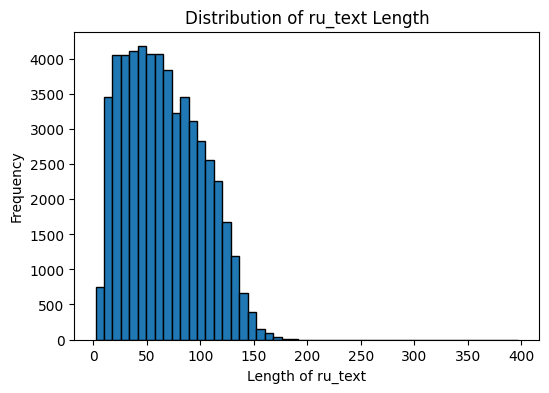

count    54263.000000
mean        65.577318
std         35.671281
min          0.000000
25%         36.000000
50%         62.000000
75%         92.000000
max        397.000000
Name: text_length, dtype: float64


In [10]:
import matplotlib.pyplot as plt

# Calculate the length of each text
df_cleaned['text_length'] = df_cleaned['text'].apply(len)

# Plot the length binned plot
plt.figure(figsize=(6, 4))
df_cleaned[df_cleaned['text_length']>0]['text_length'].plot(kind='hist', bins=50, edgecolor='black')
plt.title('Distribution of ru_text Length')
plt.xlabel('Length of ru_text')
plt.ylabel('Frequency')
plt.show()

# Describe the length of the text
print(df_cleaned['text_length'].describe())

df_cleaned=df_cleaned[df_cleaned['text_length']>1]

# Drop the length column
df_cleaned.drop(columns=['text_length'], inplace=True)

In [11]:
# Drop rows with empty text
df_cleaned.dropna(subset=['text'], inplace=True)

In [12]:
df_go['general_emotion'].value_counts()


general_emotion
happiness    20362
neutral      16862
anger         6227
surprise      5736
sadness       3450
fear           816
disgust        810
Name: count, dtype: int64

In [13]:
df_cleaned.shape

(54257, 3)

# DATASET from pipeline

In [14]:
data = pd.read_csv('2024-25c-fai2-adsai-group-team-28-y2c/Deliverables/Task4 - NLP features/group 28_url1.csv') # server
# data = pd.read_csv('group 28_url1.csv')

# Drop first 3 columns
data = data.drop(data.columns[0:3], axis=1)
data = data.drop(columns=['Intensity'], axis=1)
data.dropna(inplace=True)

# Function to map emotions to general categories
def map4data(emotion):
    for category, emotions in mapping_emotions.items():
        if emotion in emotions:
            return category
    return None  # In case an emotion is not found in the dictionary

# Apply the mapping function to create a new column
data["general_emotion"] = data["Emotion"].map(map4data)

# Rename columns
data = data.rename(columns={"Corrected Sentence": "ru_text", "Emotion": "emotion", 'Translation': 'text'})

# Clean data
data_cleaned = data.copy()
data_cleaned['text'] = data['text'].apply(text_preprocessing_pipeline)

# Drop column emotion
data_cleaned = data_cleaned.drop(columns=['emotion'], axis=1)

data_cleaned.head()

,ru_text,text,general_emotion
0,С понедельника по пятницу пять совершенно разн...,from monday to friday five completely differen...,neutral
1,Каждый из них имеет одинаковые условия при пок...,each of them has the same conditions when buyi...,neutral
2,И только три часа на приготовление ужина из тр...,and only three hours to make a dinner of three...,neutral
3,Задача каждого продемонстрировать гостям все с...,the task of everyone is to demonstrate to gues...,neutral
4,Что подать к столу и как развлекать гостей реш...,what to serve to the table and how to entertai...,neutral


In [15]:
# Show the shapes of two datasets
print(df_cleaned.shape)
print(data_cleaned.shape)

(54257, 3)
(1044, 3)


In [16]:
# Calculate the length of each text
data_cleaned['text_length'] = data_cleaned['text'].apply(len)

data_cleaned=data_cleaned[data_cleaned['text_length']>=1]

# Describe the length of the text
print(data_cleaned['text_length'].describe())

# Drop the length column
data_cleaned.drop(columns=['text_length'], inplace=True)

count    1043.000000
mean       35.060403
std        21.147167
min         1.000000
25%        19.000000
50%        33.000000
75%        48.000000
max       151.000000
Name: text_length, dtype: float64


In [17]:
data_cleaned['general_emotion'].value_counts()

general_emotion
neutral      398
happiness    385
surprise     186
anger         37
sadness       20
disgust       12
fear           5
Name: count, dtype: int64

In [40]:
# Combine three datasets
combined_df = pd.concat([df_cleaned, data_cleaned], ignore_index=True)

In [41]:
# Show the shapes of two datasets
print(combined_df.shape)

(55300, 3)


# Dataset from other teams

In [18]:
import glob
import os

def process_datasets(folder_path, text_preprocessing_pipeline, mapping_emotions):
    all_data = []
    
    for file in glob.glob(f'{folder_path}/*.csv'):
        data = pd.read_csv(file)
        
        # Drop first 3 columns and 'Intensity' column if they exist
        data = data.drop(data.columns[0:3], axis=1)
        if 'Intensity' in data.columns:
            data = data.drop(columns=['Intensity'], axis=1)
        
        data.dropna(inplace=True)
        
        # Function to map emotions to general categories
        def map4data(emotion):
            for category, emotions in mapping_emotions.items():
                if emotion in emotions:
                    return category
            return None  # In case an emotion is not found in the dictionary
        
        # Apply the mapping function to create a new column
        if "Emotion" in data.columns:
            data["general_emotion"] = data["Emotion"].map(map4data)
            
        # Rename columns
        data = data.rename(columns={"Corrected Sentence": "ru_text", "Emotion": "emotion", 'Translation': 'text'})

        # Debugging: Print column names if 'text' is missing
        if 'text' not in data.columns:
            print(f"Warning: 'text' column missing in {file}. Available columns: {data.columns.tolist()}")
        else:
            # Clean data
            data['text'] = data['text'].apply(text_preprocessing_pipeline)
        
        # Drop 'emotion' column if it exists
        if 'emotion' in data.columns:
            data = data.drop(columns=['emotion'], axis=1)
        
        all_data.append(data)
    
    # Concatenate all processed data
    if all_data:
        final_data = pd.concat(all_data, ignore_index=True)
        return final_data
    else:
        return pd.DataFrame()


# Example usage
folder_path = 'groups_data'
processed_data = process_datasets(folder_path, text_preprocessing_pipeline, mapping_emotions)

In [19]:
# Calculate the length of each text
processed_data['text_length'] = processed_data['text'].apply(len)

processed_data=processed_data[processed_data['text_length']>=1]

# Describe the length of the text
print(processed_data['text_length'].describe())

# Drop the length column
processed_data.drop(columns=['text_length'], inplace=True)

count    31967.000000
mean        30.705853
std         21.674419
min          1.000000
25%         16.000000
50%         27.000000
75%         42.000000
max        516.000000
Name: text_length, dtype: float64


In [20]:
processed_data['general_emotion'].value_counts()

general_emotion
neutral      12425
surprise      7479
happiness     6688
anger         3071
sadness       1300
fear           839
disgust        165
Name: count, dtype: int64

In [21]:
print(processed_data.shape)

(31967, 3)


## Balanced Dataset

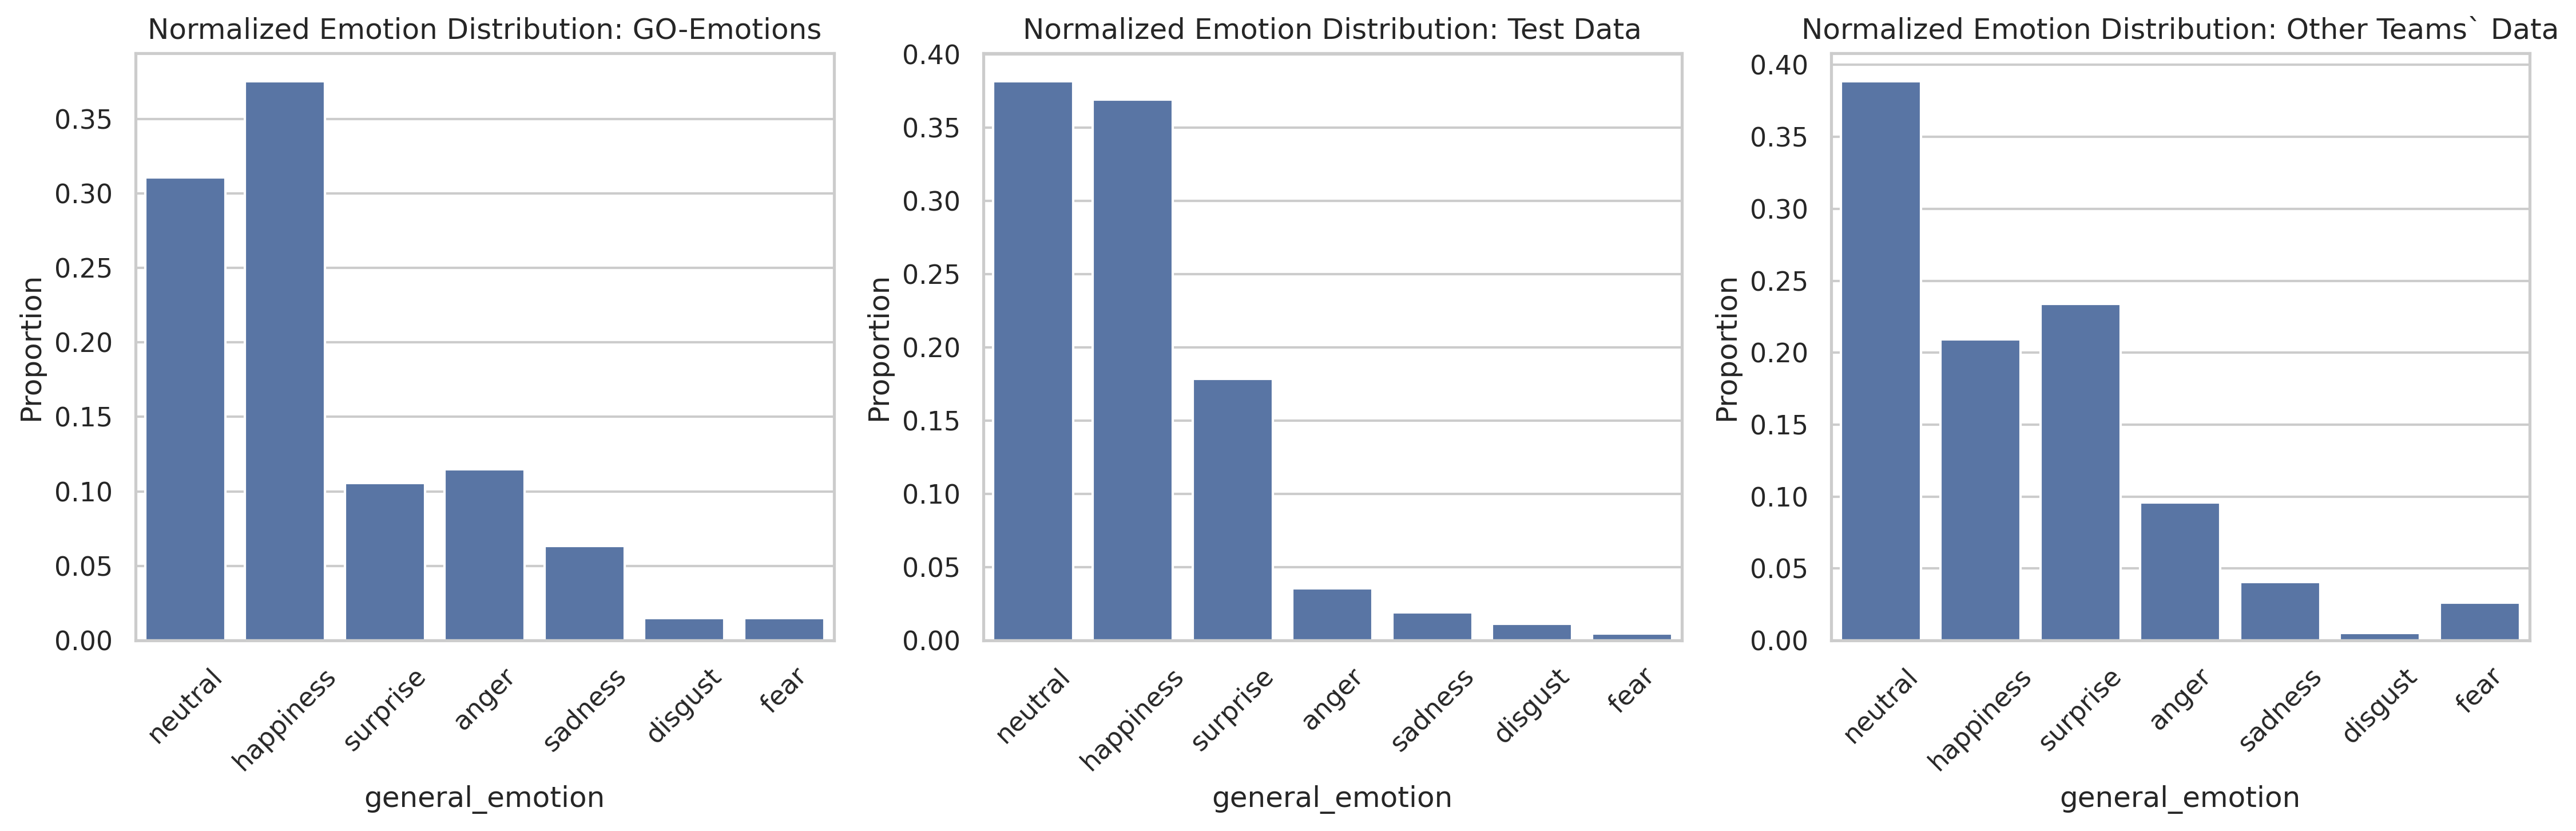

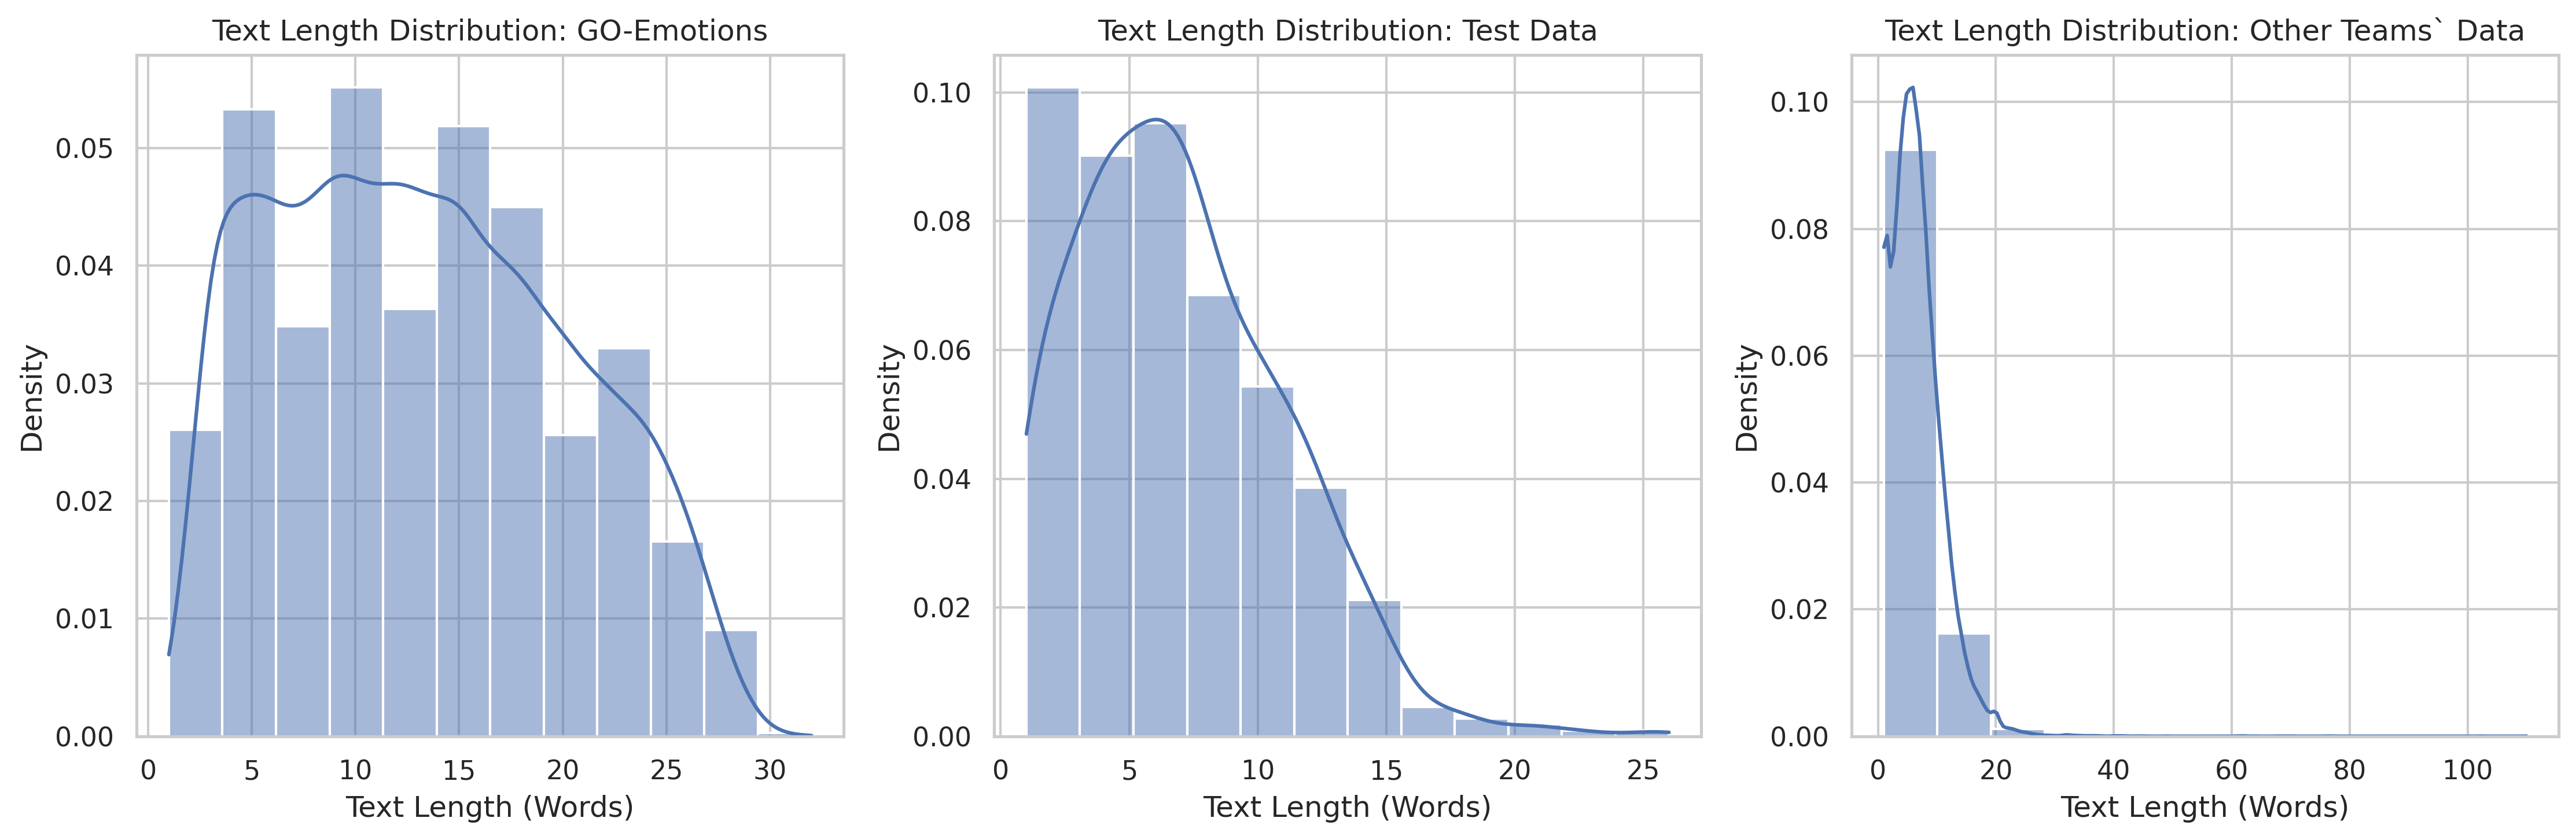

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure plots are visually appealing
sns.set(style="whitegrid")

# List of datasets with names
datasets = {
    "GO-Emotions": df_cleaned,
    "Test Data": data_cleaned,
    "Other Teams` Data": processed_data
}

# Emotion Distribution Plot with consistent x-axis category order
order = ['neutral','happiness', 'surprise', 'anger',  'sadness', 'disgust', 'fear']
plt.figure(figsize=(15, 5), dpi=300)
for i, (name, df) in enumerate(datasets.items(), 1):
    plt.subplot(1, 3, i)
    emotion_counts = df['general_emotion'].value_counts(normalize=True)
    emotion_counts = emotion_counts.reindex(order)  # Ensure same category order for all plots
    sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
    plt.title(f'Normalized Emotion Distribution: {name}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Text Length Distribution Plot
plt.figure(figsize=(15, 5), dpi=300)
for i, (name, df) in enumerate(datasets.items(), 1):
    plt.subplot(1, 3, i)
    text_lengths = df['text'].apply(lambda x: len(str(x).split()))
    sns.histplot(text_lengths, stat='density', bins=12, kde=True)
    plt.title(f'Text Length Distribution: {name}')
    plt.xlabel('Text Length (Words)')
    plt.ylabel('Density')
plt.tight_layout()
plt.show()


In [40]:
# Sizes of datasets
print("GO-Emotions dataset size:", df_cleaned.shape)
print("Test Data dataset size:", data_cleaned.shape)
print("Other Teams` Data dataset size:", processed_data.shape)

GO-Emotions dataset size: (54257, 3)
Test Data dataset size: (1043, 3)
Other Teams` Data dataset size: (31967, 3)


In [46]:
# # Example: Assume df_combined has a 'general_emotion' column
# class_counts = combined_df['general_emotion'].value_counts()
# min_count = class_counts.min()  # Get the smallest class count

# # Downsample each class to the min_count
# combined_df = combined_df.groupby('general_emotion').apply(lambda x: x.sample(n=min_count, random_state=42))

# # Reset index after groupby operation
# combined_df = combined_df.reset_index(drop=True)

# print(combined_df['general_emotion'].value_counts())  # Verify balance

In [47]:
combined_df = pd.concat([processed_data, combined_df], ignore_index=True)
print(combined_df.shape)

(87267, 3)


In [48]:
# print last 1044 rows
print(combined_df.tail(1044))

                                                 ru_text  \
86223      ::но мне нравится детская челка:: /tiny voice   
86224  С понедельника по пятницу пять совершенно разн...   
86225  Каждый из них имеет одинаковые условия при пок...   
86226  И только три часа на приготовление ужина из тр...   
86227  Задача каждого продемонстрировать гостям все с...   
...                                                  ...   
87262                                                Да.   
87263  Я его половую принадлежность даже не могу понять.   
87264  О чём вы говорите? У него волосы длиннее, чем ...   
87265                                         Завидуешь.   
87266                                     Пик, пик, пик.   

                                                    text general_emotion  
86223                   but i like baby bangs tiny voice       happiness  
86224  from monday to friday five completely differen...         neutral  
86225  each of them has the same conditions when buyi.

In [49]:
combined_df.to_parquet("group_combined_no_features.parquet")

# FUNCTIONS

RUN TO GET A MODEL FOR EMBEDDINGS wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz


gunzip cc.ru.300.bin.gz


In [22]:
# Load the pre-trained Russian FastText embeddings
model_path = "cc.en.300.bin"  # Ensure the correct path
fasttext_model = gensim.models.fasttext.load_facebook_vectors(model_path)

INFO: loading 2000000 words for fastText model from cc.en.300.bin
INFO: FastText lifecycle event {'params': 'FastText<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2025-03-31T14:10:58.186778', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.0-134-generic-x86_64-with-glibc2.35', 'event': 'created'}
INFO: Updating model with new vocabulary
INFO: FastText lifecycle event {'msg': 'added 2000000 new unique words (100.00% of original 2000000) and increased the count of 0 pre-existing words (0.00% of original 2000000)', 'datetime': '2025-03-31T14:11:08.306810', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.0-134-generic-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
INFO: deleting the raw counts dictionary of 2000000 items
INFO: sample=1e-05 downsamples 3498 most-common words
INFO: FastText lifecycle event {'msg': 'downsampling leaves estimated 195157728967.5026

In [23]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load Russian NLP model
logging.info("Loading spaCy model...")
# in case different language is needed change the ru to other language code
nlp = spacy.load('en_core_web_sm')

# Add EntityRuler to pipeline
logging.info("Adding custom entity patterns...")
ruler = nlp.add_pipe("entity_ruler", before="ner")
patterns = [
    {"label": "PER", "pattern": name} for name in ["lidia"]
] + [
    {"label": "ORG", "pattern": name} for name in ["called dinner"]
]
ruler.add_patterns(patterns)

def seq2vec(sequences):
    ## Vectorize POS tags
    # 1. Initialize and fit Keras Tokenizer
    tokenizer = Tokenizer(oov_token="<UNK>", filters='')
    tokenizer.fit_on_texts(sequences)
    
    # 2. Convert tags to integers
    encoded_sequences = tokenizer.texts_to_sequences(sequences)
    
    # 3. Calculate max length if not provided
    max_len = max(len(seq) for seq in encoded_sequences)
    
    # 3. Pad sequences
    padded_sequences = pad_sequences(
        encoded_sequences,
        maxlen=max_len,
        padding='post',
        truncating='post',
        value=0
    )

    return list(padded_sequences)

def get_tokens(data_set_column, language='russian'):
    """
    Tokenize sentences using NLTK.
    """
    return [nltk.word_tokenize(sent, language=language) for sent in tqdm(data_set_column, desc="Tokenizing sentences")]
    

def get_POS(data_set_column):
    logging.info("Extracting POS tags from sentences using batch processing")
    
    # Process all sentences in parallel using nlp.pipe() with tqdm for progress bar
    docs = list(tqdm(nlp.pipe(data_set_column, disable=["ner", "parser"]), total=len(data_set_column), desc="Extracting POS tags"))

    # Extract POS tags efficiently
    pos_sequences = [[token.pos_ for token in doc] for doc in docs]
    
    padded_output = seq2vec(pos_sequences)

    logging.info("POS tags extracted successfully.")

    return padded_output

def get_tf_idf_with_svd(data_set_column, n_components=100, language='russian'):
    """
    Compute TF-IDF vectors and reduce their dimensions using SVD.
    
    Parameters:
    - data_set_column: List of text data
    - n_components: Number of dimensions to keep after SVD
    
    Returns:
    - Reduced dimensionality TF-IDF matrix as a list
    """
    # stop_words = list(nltk.corpus.stopwords.words(language))

    logging.info("Computing TF-IDF...")
    tfidf = TfidfVectorizer(min_df=3, ngram_range=(1, 3), sublinear_tf=True)
    tfidf_matrix = tfidf.fit_transform(data_set_column)

    logging.info("Applying SVD for dimensionality reduction...")
    svd = TruncatedSVD(n_components=n_components)
    reduced_matrix = svd.fit_transform(tfidf_matrix)

    return reduced_matrix.tolist()

def get_sentiment(data_set_column):
    """
    Compute sentiment scores.
    """
    return [TextBlob(sent).sentiment.polarity for sent in tqdm(data_set_column, desc="Computing sentiment scores")]

def get_pretrained_embeddings(data_set_column):
    """
    Extract sentence embeddings using a pre-trained FastText model (Russian, 300D).
    """
    def sentence_embedding(sentence):
        word_vectors = [fasttext_model[word] for word in sentence if word in fasttext_model]
        if not word_vectors:
            return np.zeros(fasttext_model.vector_size)  # Return zero vector if no words are found
        return np.mean(word_vectors, axis=0)  # Average word vectors to get sentence embedding

    embeddings = list([sentence_embedding(sentence) for sentence in data_set_column])
    return embeddings

def train_custom_word2vec(data_set_column):
    """
    Train a custom Word2Vec model.
    """
    logging.info("Training Word2Vec model...")
    return Word2Vec(sentences=data_set_column, vector_size=300, window=5, workers=4)

def get_custom_embeddings(data_set_column, model):
    """
    Generate sentence embeddings using a trained Word2Vec model.
    """
    sentence_embeddings = []
    
    for sentence in data_set_column:
        vectors = [model.wv[word] for word in sentence if word in model.wv]
        if vectors:
            avg_vector = sum(vectors) / len(vectors)
        else:
            avg_vector = [0] * model.vector_size
        sentence_embeddings.append(avg_vector)
    
    return sentence_embeddings

def extract_named_entities_per_token(data_set_column):
    named_entities = []
    for sent in tqdm(data_set_column, desc="Extracting named entities"):
        doc = nlp(sent)
        # Initialize a list of None values (for non-entity words)
        labels = [str(np.nan)] * len(doc)
        # Assign entity labels to tokens covered by entities
        for ent in doc.ents:
            for token in ent:
                labels[token.i] = ent.label_
        
        named_entities.append(labels)

    padded_output = seq2vec(named_entities)

    return padded_output

# def lemmatized(data_set_column):
#     """
#     Lemmatize the text.
#     Using spacy.
#     """
#     lemmatizer = nlp.get_pipe("lemmatizer")
#     lemmatizer.add_pipe("lemmatizer", config={"mode": "pymorphy3"})

#     return [[token.lemma_ for token in nlp(sentence, config)] for sentence in tqdm(data_set_column, desc="Lemmatizing")]
    
# def stop_words_filtering(tokenized_text, language='russian'):
#     """
#     Remove stop words.
#     """
#     stop_words = set(nltk.corpus.stopwords.words(language))
#     return [[word for word in sentence if word.lower() not in stop_words] for sentence in tqdm(tokenized_text, desc="Filtering stop words")]
    

logging.info("Pipeline setup complete.")

INFO: Loading spaCy model...
INFO: Adding custom entity patterns...
INFO: Pipeline setup complete.


In [24]:
# Change the language code if needed
# combined_df['cleaned_text'] = combined_df['ru_text'].str.lower()
combined_df['tokenized'] = get_tokens(combined_df['text'], language='english')
combined_df['pos_tags'] = get_POS(combined_df['text'])
combined_df['TF_IDF'] = get_tf_idf_with_svd(combined_df['text'], n_components=3, language='english')
combined_df['named_entities'] = extract_named_entities_per_token(combined_df['text'])

Tokenizing sentences: 100%|██████████| 55307/55307 [00:03<00:00, 15106.35it/s]
INFO: Extracting POS tags from sentences using batch processing
Extracting POS tags: 100%|██████████| 55307/55307 [00:52<00:00, 1059.23it/s]
INFO: POS tags extracted successfully.
INFO: Computing TF-IDF...
INFO: Applying SVD for dimensionality reduction...
Extracting named entities: 100%|██████████| 55307/55307 [04:06<00:00, 224.62it/s]


In [25]:
combined_df['pretrained_embeddings'] = get_pretrained_embeddings(combined_df['tokenized'])

custom_word2vec = train_custom_word2vec(combined_df['tokenized'])

combined_df['custom_embeddings'] = get_custom_embeddings(combined_df['tokenized'], custom_word2vec)

INFO: Training Word2Vec model...
INFO: collecting all words and their counts
INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO: PROGRESS: at sentence #10000, processed 129363 words, keeping 11930 word types
INFO: PROGRESS: at sentence #20000, processed 260057 words, keeping 17426 word types
INFO: PROGRESS: at sentence #30000, processed 389786 words, keeping 21459 word types
INFO: PROGRESS: at sentence #40000, processed 519928 words, keeping 25013 word types
INFO: PROGRESS: at sentence #50000, processed 648979 words, keeping 28073 word types
INFO: collected 29459 word types from a corpus of 711456 raw words and 55307 sentences
INFO: Creating a fresh vocabulary
INFO: Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 7417 unique words (25.18% of original 29459, drops 22042)', 'datetime': '2025-03-31T14:17:00.311662', 'gensim': '4.3.3', 'python': '3.9.21 (main, Dec 11 2024, 16:24:11) \n[GCC 11.2.0]', 'platform': 'Linux-5.15.0-134-generic-x86_64-with

In [26]:
combined_df.head()

,ru_text,text,general_emotion,emotion,tokenized,pos_tags,TF_IDF,named_entities,pretrained_embeddings,custom_embeddings
0,"Моя любимая еда — это все, что мне не приходил...",my favorite food is anything i did not have to...,neutral,NaN,"[my, favorite, food, is, anything, i, did, not...","[4, 8, 2, 5, 4, 4, 5, 10, 5, 10, 3, 4, 0, 0, 0...","[0.11172039071003351, -0.03171813233885921, -0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, ...","[0.009213074, -0.002746407, -0.040258992, 0.07...","[0.06017999, 0.16348511, 0.13423847, 0.0592636..."
1,"Теперь, если он покончит с собой, все будут ду...",now if he does off himself everyone will think...,neutral,NaN,"[now, if, he, does, off, himself, everyone, wi...","[9, 12, 4, 5, 7, 4, 4, 5, 3, 4, 3, 3, 6, 2, 3,...","[0.0858125022007984, -0.020610967402045446, -0...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.0069838553, -0.048969656, -0.011184665, 0.0...","[-0.081190936, 0.13158128, 0.03176073, -0.0415..."
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,why the fuck is bayless isoing,anger,NaN,"[why, the, fuck, is, bayless, isoing]","[12, 6, 2, 5, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.07178947329652366, -0.03150039616714909, 0....","[2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.021802934, -0.048706856, -0.0108602615, 0....","[0.1789749, 0.228133, 0.03257048, -0.035139818..."
3,Чтобы она почувствовала угрозу,to make her feel threatened,fear,NaN,"[to, make, her, feel, threatened]","[10, 3, 4, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.046774066484895516, -0.005518367006165741, ...","[2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.013276299, -0.057418138, 0.034888826, 0.079...","[-0.13880834, -0.19159278, 0.12964416, 0.08714..."
4,Грязные южные дрочники,dirty southern wankers,anger,NaN,"[dirty, southern, wankers]","[8, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0013217289712883344, 0.0005557374690066706,...","[2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-0.03646226, -0.030779809, -0.04153761, 0.072...","[-0.015810128, 0.13451158, -0.026801381, 0.001..."


In [27]:
np.unique([seq for seq in combined_df['pos_tags']])

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int32)

In [28]:
np.unique([seq for seq in combined_df['named_entities']])

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int32)

In [29]:
# ner = data[['Corrected Sentence', 'Named_Entities']]
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.cluster import DBSCAN
# import plotly.express as px
# import numpy as np

# embeddings = np.array(data['Pretrained_embeddings'].tolist())
# sentences = data['Corrected Sentence']

# # Apply t-SNE to reduce dimensions
# embeddings_2d = TSNE(n_components=2, perplexity=5, random_state=42).fit_transform(embeddings)

# # Apply DBSCAN clustering
# dbscan = DBSCAN(eps=2, min_samples=2).fit(embeddings_2d)
# labels = dbscan.labels_

# # Create DataFrame for visualization
# df = pd.DataFrame({
#     "x": embeddings_2d[:, 0],
#     "y": embeddings_2d[:, 1],
#     "sentence": sentences,
#     "cluster": labels.astype(str)
# })

# # Plot interactive scatter plot
# fig = px.scatter(
#     df, x="x", y="y", color="cluster",
#     hover_data={"sentence": True, "x": False, "y": False, "cluster": True},
#     title="Sentence Embeddings Visualized with t-SNE and DBSCAN"
# )
# fig.show()

In [30]:
# Convert array columns to string before saving
output_df = combined_df.copy()
output_df['TF_IDF'] = combined_df['TF_IDF'].apply(lambda x: ','.join(map(str, x)))
output_df['pretrained_embeddings'] = combined_df['pretrained_embeddings'].apply(lambda x: ','.join(map(str, x)))
output_df['custom_embeddings'] = combined_df['custom_embeddings'].apply(lambda x: ','.join(map(str, x)))
output_df['pos_tags'] = combined_df['pos_tags'].apply(lambda x: ','.join(map(str, x)))
output_df['named_entities'] = combined_df['named_entities'].apply(lambda x: ','.join(map(str, x)))

In [31]:
# Drop Tokenized and POS_tags columns
output_df = output_df.drop(["tokenized"], axis=1)

In [32]:
output_df.head()

,ru_text,text,general_emotion,emotion,pos_tags,TF_IDF,named_entities,pretrained_embeddings,custom_embeddings
0,"Моя любимая еда — это все, что мне не приходил...",my favorite food is anything i did not have to...,neutral,NaN,"4,8,2,5,4,4,5,10,5,10,3,4,0,0,0,0,0,0,0,0,0,0,...","0.11172039071003351,-0.03171813233885921,-0.00...","2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,...","0.009213074,-0.002746407,-0.040258992,0.071187...","0.06017999,0.16348511,0.13423847,0.05926363,0...."
1,"Теперь, если он покончит с собой, все будут ду...",now if he does off himself everyone will think...,neutral,NaN,"9,12,4,5,7,4,4,5,3,4,3,3,6,2,3,7,2,9,7,9,8,0,0...","0.0858125022007984,-0.020610967402045446,-0.03...","2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,...","0.0069838553,-0.048969656,-0.011184665,0.02328...","-0.081190936,0.13158128,0.03176073,-0.04154391..."
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,why the fuck is bayless isoing,anger,NaN,"12,6,2,5,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...","0.07178947329652366,-0.03150039616714909,0.043...","2,2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","-0.021802934,-0.048706856,-0.0108602615,0.0664...","0.1789749,0.228133,0.03257048,-0.035139818,0.0..."
3,Чтобы она почувствовала угрозу,to make her feel threatened,fear,NaN,"10,3,4,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...","0.046774066484895516,-0.005518367006165741,-0....","2,2,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.013276299,-0.057418138,0.034888826,0.0790269...","-0.13880834,-0.19159278,0.12964416,0.0871402,0..."
4,Грязные южные дрочники,dirty southern wankers,anger,NaN,"8,8,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","0.0013217289712883344,0.0005557374690066706,-0...","2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...","-0.03646226,-0.030779809,-0.04153761,0.0724572...","-0.015810128,0.13451158,-0.026801381,0.0015691..."


In [34]:
# Drop emotion column
output_df = output_df.drop(["emotion"], axis=1)

In [36]:
output_df.to_parquet('nlp_for_en.parquet', index=False)